https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/python-replications/historical-sp-500-index-constituents

https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/daily-stock-file/

https://wrds-www.wharton.upenn.edu/data-dictionary/contrib_global_factor/global_factor/

In [1]:
import pandas as pd
import wrds
from matplotlib import pyplot as plt

In [2]:
conn = wrds.Connection()

Loading library list...
Done


In [3]:
begdate = '2015-01-01'
enddate = '2022-12-30'

Get S&P 500 Constituent

In [4]:
sp500 = conn.raw_sql(f"""
                        select a.*, b.date
                        from crsp.msp500list as a,
                        crsp.msf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='{begdate}'
                        and b.date<='{enddate}'
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])

In [5]:
mse = conn.raw_sql("""
                        select comnam, namedt, nameendt, 
                        permno, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

# if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

In [6]:
# Merge with SP500 data
sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

# Impose the date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                            & (sp500_full.date<=sp500_full.nameendt)]

In [7]:
sp500 = sp500_full.drop_duplicates('permno')
sp500 = sp500[['permno', 'comnam', 'ticker']]
sp500

,permno,comnam,ticker
3,10104.0,ORACLE CORP,ORCL
5,10107.0,MICROSOFT CORP,MSFT
10,10138.0,T ROWE PRICE GROUP INC,TROW
25,10145.0,HONEYWELL INTERNATIONAL INC,HON
35,10147.0,E M C CORP MA,EMC
...,...,...,...
331238,16581.0,INVITATION HOMES INC,INVH
331770,86288.0,COSTAR GROUP INC,CSGP
334855,12476.0,TARGA RESOURCES CORP,TRGP
339504,82276.0,ARCH CAPITAL GROUP LTD NEW,ACGL


Read Price Volume data for S&P500

In [8]:
permno_list_sp500 = sp500['permno'].astype('int').to_list()
formatted_permnos_sp500 = ",".join(["'{}'".format(permno) for permno in permno_list_sp500])

In [9]:
query = f"""
SELECT 
    permno, date, prc, vol, openprc, askhi, bidlo, ret, shrout
FROM 
    crsp_a_stock.dsf 
WHERE 
    permno IN ({formatted_permnos_sp500}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

price_vol_sp500 = conn.raw_sql(query)

In [10]:
price_vol_sp500['date'] = pd.to_datetime(price_vol_sp500['date'])
price_vol_sp500['yyyy-mm'] = price_vol_sp500['date'].dt.strftime('%Y-%m')
price_vol_sp500

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm
0,10104.0,2015-01-02,44.330002,15070165.0,45.020000,45.189800,43.970001,-0.014232,4391367.0,2015-01
1,10104.0,2015-01-05,43.590000,18375801.0,44.160000,44.250000,43.580002,-0.013986,4391367.0,2015-01
2,10104.0,2015-01-06,43.139999,19229461.0,44.060001,44.180000,42.990002,-0.010323,4391367.0,2015-01
3,10104.0,2015-01-07,43.150002,13502164.0,43.330002,43.520000,43.009998,0.000232,4391367.0,2015-01
4,10104.0,2015-01-08,43.410000,17516877.0,43.630001,43.939999,43.380001,0.006025,4391367.0,2015-01
...,...,...,...,...,...,...,...,...,...,...
221715,93436.0,2022-12-23,123.150002,166917212.0,126.370003,128.617294,121.019997,-0.017551,3157752.0,2022-12
221716,93436.0,2022-12-27,109.099998,208446557.0,117.495003,119.669998,108.760002,-0.114089,3157752.0,2022-12
221717,93436.0,2022-12-28,112.709999,220818648.0,110.349998,116.269997,108.239998,0.033089,3157752.0,2022-12
221718,93436.0,2022-12-29,121.820000,221592714.0,120.385002,123.570000,117.495003,0.080827,3157752.0,2022-12


Get a larger universe, where mktcap > 300M and dollar vol > 10M

In [11]:
query = f"""
SELECT 
    DISTINCT permno, date, market_equity, dolvol_126d, excntry, gics
FROM 
    contrib_global_factor.global_factor
WHERE
    date ='{enddate}' AND excntry = 'USA'
"""

all = conn.raw_sql(query)

In [12]:
all.dropna(inplace=True)
all = all[(all['market_equity'] > 300) & (all['dolvol_126d'] > 10e6)]
all

,permno,date,market_equity,dolvol_126d,excntry,gics
4,91915.0,2022-12-30,1042.880482,3.968570e+07,USA,50202010.0
34,90979.0,2022-12-30,1917.080211,6.701488e+07,USA,25203010.0
55,19893.0,2022-12-30,339.862022,5.008955e+07,USA,50203010.0
75,21895.0,2022-12-30,2369.825136,2.436594e+07,USA,45103010.0
97,13783.0,2022-12-30,830.915008,2.862788e+07,USA,15104040.0
...,...,...,...,...,...,...
26446,20053.0,2022-12-30,5461.947789,4.016017e+07,USA,40101015.0
26454,79444.0,2022-12-30,1558.921531,2.367499e+07,USA,10102020.0
26485,17676.0,2022-12-30,6408.602093,2.837874e+07,USA,20104010.0
26494,88462.0,2022-12-30,1183.638297,8.008280e+07,USA,35202010.0


In [13]:
all = pd.merge(all, mse, how='left', on='permno')
all = all.drop_duplicates('permno')
all = all[['permno', 'comnam', 'ticker']]
all

,permno,comnam,ticker
0,91915.0,CINEMARK HOLDINGS INC,CNK
3,90979.0,UNDER ARMOUR INC,UARM
11,19893.0,FUBOTV INC,FUBO
12,21895.0,FRESHWORKS INC,FRSH
13,13783.0,SIBANYE GOLD LTD,SBGL
...,...,...,...
10432,20053.0,C B & T BANCSHARES INC,CBTB
10442,79444.0,STONE ENERGY CORP,SGY
10453,17676.0,NVENT ELECTRIC PLC,NVT
10455,88462.0,PAIN THERAPEUTICS INC,PTIE


Read Price Volume data for our universe

In [14]:
permno_list_all = all['permno'].astype('int').to_list()
formatted_permnos_all = ",".join(["'{}'".format(permno) for permno in permno_list_all])

In [15]:
query = f"""
SELECT 
    permno, date, prc, vol, openprc, askhi, bidlo, ret, shrout
FROM 
    crsp_a_stock.dsf 
WHERE 
    permno IN ({formatted_permnos_all}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

price_vol_all = conn.raw_sql(query)

In [16]:
price_vol_all['date'] = pd.to_datetime(price_vol_all['date'])
price_vol_all['yyyy-mm'] = price_vol_all['date'].dt.strftime('%Y-%m')
price_vol_all

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm
0,10026.0,2015-01-02,107.690002,88837.0,109.180000,109.445999,106.809998,-0.009929,18678.0,2015-01
1,10026.0,2015-01-05,107.239998,61805.0,107.410004,108.430000,106.760002,-0.004179,18678.0,2015-01
2,10026.0,2015-01-06,107.269997,80455.0,107.839996,108.690002,106.184998,0.000280,18678.0,2015-01
3,10026.0,2015-01-07,108.730003,58792.0,107.699997,108.769997,106.495003,0.013611,18678.0,2015-01
4,10026.0,2015-01-08,110.320000,56302.0,109.480003,111.279999,109.110001,0.014623,18678.0,2015-01
...,...,...,...,...,...,...,...,...,...,...
128576,93436.0,2022-12-23,123.150002,166917212.0,126.370003,128.617294,121.019997,-0.017551,3157752.0,2022-12
128577,93436.0,2022-12-27,109.099998,208446557.0,117.495003,119.669998,108.760002,-0.114089,3157752.0,2022-12
128578,93436.0,2022-12-28,112.709999,220818648.0,110.349998,116.269997,108.239998,0.033089,3157752.0,2022-12
128579,93436.0,2022-12-29,121.820000,221592714.0,120.385002,123.570000,117.495003,0.080827,3157752.0,2022-12


Read GICS data for sp500

In [17]:
query = f"""
SELECT 
    DISTINCT permno, gics, date
FROM 
    contrib_global_factor.global_factor
WHERE
    permno IN ({formatted_permnos_sp500}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

gics_sp500 = conn.raw_sql(query)

In [18]:
gics_sp500['date'] = pd.to_datetime(gics_sp500['date'])
gics_sp500['yyyy-mm'] = gics_sp500['date'].dt.strftime('%Y-%m')
gics_sp500.drop(columns='date', inplace=True)
gics_sp500

,permno,gics,yyyy-mm
0,87717.0,20301010.0,2019-12
1,19502.0,30101010.0,2020-06
2,44329.0,35101010.0,2021-07
3,60442.0,40101015.0,2018-09
4,24328.0,10102020.0,2015-07
...,...,...,...
58326,92157.0,45203020.0,2018-12
58327,58246.0,40203010.0,2021-07
58328,10516.0,30202010.0,2015-10
58329,89641.0,45202030.0,2015-12


Merge price_vol and GICS information for sp500

In [19]:
price_vol_gics_sp500 = pd.merge(price_vol_sp500, gics_sp500, how='left', on=['permno', 'yyyy-mm'])
price_vol_gics_sp500 = pd.merge(price_vol_gics_sp500, sp500, how='left', on=['permno'])
price_vol_gics_sp500

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker
0,10104.0,2015-01-02,44.330002,15070165.0,45.020000,45.189800,43.970001,-0.014232,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
1,10104.0,2015-01-05,43.590000,18375801.0,44.160000,44.250000,43.580002,-0.013986,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
2,10104.0,2015-01-06,43.139999,19229461.0,44.060001,44.180000,42.990002,-0.010323,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
3,10104.0,2015-01-07,43.150002,13502164.0,43.330002,43.520000,43.009998,0.000232,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
4,10104.0,2015-01-08,43.410000,17516877.0,43.630001,43.939999,43.380001,0.006025,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221715,93436.0,2022-12-23,123.150002,166917212.0,126.370003,128.617294,121.019997,-0.017551,3157752.0,2022-12,25102010.0,TESLA INC,TSLA
1221716,93436.0,2022-12-27,109.099998,208446557.0,117.495003,119.669998,108.760002,-0.114089,3157752.0,2022-12,25102010.0,TESLA INC,TSLA
1221717,93436.0,2022-12-28,112.709999,220818648.0,110.349998,116.269997,108.239998,0.033089,3157752.0,2022-12,25102010.0,TESLA INC,TSLA
1221718,93436.0,2022-12-29,121.820000,221592714.0,120.385002,123.570000,117.495003,0.080827,3157752.0,2022-12,25102010.0,TESLA INC,TSLA


Read GICS data for our universe

In [20]:
query = f"""
SELECT 
    DISTINCT permno, gics, date
FROM 
    contrib_global_factor.global_factor
WHERE
    permno IN ({formatted_permnos_all}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

gics_all = conn.raw_sql(query)

In [21]:
gics_all['date'] = pd.to_datetime(gics_all['date'])
gics_all['yyyy-mm'] = gics_all['date'].dt.strftime('%Y-%m')
gics_all.drop(columns='date', inplace=True)
gics_all

,permno,gics,yyyy-mm
0,15071.0,35203010.0,2016-07
1,19502.0,30101010.0,2020-06
2,20583.0,10102020.0,2022-10
3,44329.0,35101010.0,2021-07
4,24328.0,10102020.0,2015-07
...,...,...,...
173714,24969.0,55103010.0,2022-02
173715,18770.0,35201010.0,2021-07
173716,14071.0,60101060.0,2020-02
173717,85234.0,20201080.0,2021-06


Merge price_vol and GICS information for sp500

In [22]:
price_vol_gics_all = pd.merge(price_vol_all, gics_all, how='left', on=['permno', 'yyyy-mm'])
price_vol_gics_all = pd.merge(price_vol_gics_all, all, how='left', on=['permno'])
price_vol_gics_all

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker
0,10026.0,2015-01-02,107.690002,88837.0,109.180000,109.445999,106.809998,-0.009929,18678.0,2015-01,30202030.0,J & J SNACK FOODS CORP,JJSF
1,10026.0,2015-01-05,107.239998,61805.0,107.410004,108.430000,106.760002,-0.004179,18678.0,2015-01,30202030.0,J & J SNACK FOODS CORP,JJSF
2,10026.0,2015-01-06,107.269997,80455.0,107.839996,108.690002,106.184998,0.000280,18678.0,2015-01,30202030.0,J & J SNACK FOODS CORP,JJSF
3,10026.0,2015-01-07,108.730003,58792.0,107.699997,108.769997,106.495003,0.013611,18678.0,2015-01,30202030.0,J & J SNACK FOODS CORP,JJSF
4,10026.0,2015-01-08,110.320000,56302.0,109.480003,111.279999,109.110001,0.014623,18678.0,2015-01,30202030.0,J & J SNACK FOODS CORP,JJSF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3628576,93436.0,2022-12-23,123.150002,166917212.0,126.370003,128.617294,121.019997,-0.017551,3157752.0,2022-12,25102010.0,TESLA MOTORS INC,TSLA
3628577,93436.0,2022-12-27,109.099998,208446557.0,117.495003,119.669998,108.760002,-0.114089,3157752.0,2022-12,25102010.0,TESLA MOTORS INC,TSLA
3628578,93436.0,2022-12-28,112.709999,220818648.0,110.349998,116.269997,108.239998,0.033089,3157752.0,2022-12,25102010.0,TESLA MOTORS INC,TSLA
3628579,93436.0,2022-12-29,121.820000,221592714.0,120.385002,123.570000,117.495003,0.080827,3157752.0,2022-12,25102010.0,TESLA MOTORS INC,TSLA


Save to parquet

In [24]:
price_vol_gics_sp500.to_parquet('../data/price_vol_gics_sp500.parquet.gzip', compression='gzip')
price_vol_gics_all.to_parquet('../data/price_vol_gics_all.parquet.gzip', compression='gzip')

In [ ]:
conn.close()

GICS map

Note that according to GICS 2023 standard, some names have changed.

In [11]:
sector_map = {
    10: 'Energy',
    15: 'Materials',
    20: 'Industrials',
    25: 'Consumer Discretionary',
    30: 'Consumer Staples',
    35: 'Health Care',
    40: 'Financials',
    45: 'Information Technology',
    50: 'Communication Services',
    55: 'Utilities',
    60: 'Real Estate'
}

In [12]:
industry_group_map = {
    1010: 'Energy',
    1510: 'Materials',
    2010: 'Capital Goods',
    2020: 'Commercial & Professional Services',
    2030: 'Transportation',
    2510: 'Automobiles & Components',
    2520: 'Consumer Durables & Apparel',
    2530: 'Consumer Services',
    2550: 'Consumer Discretionary Distribution & Retail',
    3010: 'Consumer Staples Distribution & Retail',
    3020: 'Food, Beverage & Tobacco',
    3030: 'Household & Personal Products',
    3510: 'Health Care Equipment & Services',
    3520: 'Pharmaceuticals, Biotechnology & Life Sciences',
    4010: 'Banks',
    4020: 'Financial Services',
    4030: 'Insurance',
    4510: 'Software & Services',
    4520: 'Technology Hardware & Equipment',
    4530: 'Semiconductors & Semiconductor Equipment',
    5010: 'Telecommunication Services',
    5020: 'Media & Entertainment',
    5510: 'Utilities',
    6010: 'Equity Real Estate Investment Trusts (REITs)',
    6020: 'Real Estate Management & Development'
}


# Merge industry gics

sp500

In [6]:
import pyarrow.parquet as pq

# Specify the path to your parquet.gzip file
parquet_file_path = '../data/holdings.parquet.gzip'

# Read the Parquet file using pyarrow
holdings = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
holdings = holdings.to_pandas()

holdings.head()

,rdate,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,qtrgap,lpermno,npermno,modtrade,buysale
3890200,2021-06-30,110.0,False,False,3000.0,10104.0,3000.0,2021-03-31,3000.0,0.0,1,NaN,10104.0,3000.0,1.0
3888122,2021-09-30,110.0,False,False,3000.0,10104.0,3000.0,2021-06-30,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
3886028,2021-12-31,110.0,False,False,3000.0,10104.0,3000.0,2021-09-30,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
3883846,2022-03-31,110.0,False,False,3000.0,10104.0,3000.0,2021-12-31,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
3881706,2022-06-30,110.0,False,False,3000.0,10104.0,3000.0,2022-03-31,3000.0,0.0,1,10104.0,10107.0,0.0,0.0


In [4]:
parquet_file_path = '../data/price_vol_gics_sp500.parquet.gzip'

# Read the Parquet file using pyarrow
price_vol_gics_sp500 = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
price_vol_gics_sp500 = price_vol_gics_sp500.to_pandas()

price_vol_gics_sp500.head()

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker
0,10104.0,2015-01-02,44.330002,15070165.0,45.020000,45.189800,43.970001,-0.014232,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
1,10104.0,2015-01-05,43.590000,18375801.0,44.160000,44.250000,43.580002,-0.013986,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
2,10104.0,2015-01-06,43.139999,19229461.0,44.060001,44.180000,42.990002,-0.010323,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
3,10104.0,2015-01-07,43.150002,13502164.0,43.330002,43.520000,43.009998,0.000232,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
4,10104.0,2015-01-08,43.410000,17516877.0,43.630001,43.939999,43.380001,0.006025,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL


In [18]:
holdings = holdings.rename(columns = {'rdate':'date'})
holdings['year'] = holdings['date'].dt.year

In [9]:
holdings_sp500 = holdings[holdings['permno'].isin(price_vol_gics_sp500['permno'])]

holdings_sp500 = pd.merge(holdings_sp500, price_vol_gics_sp500, on = ['date', 'permno'], how = 'left')
holdings_sp500['gics'] = holdings_sp500['gics'].fillna(0)

holdings_sp500.head()

,date,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,...,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker
0,2021-06-30,110.0,False,False,3000.0,10104.0,3000.0,2021-03-31,3000.0,0.0,...,7899840.0,77.589996,78.209999,77.580002,-0.003329,2792000.0,2021-06,45103020.0,ORACLE CORP,ORCL
1,2021-09-30,110.0,False,False,3000.0,10104.0,3000.0,2021-06-30,3000.0,0.0,...,15651919.0,91.250000,91.580002,87.120003,-0.045151,2733686.0,2021-09,45103020.0,ORACLE CORP,ORCL
2,2021-12-31,110.0,False,False,3000.0,10104.0,3000.0,2021-09-30,3000.0,0.0,...,5908158.0,88.050003,88.099998,87.180000,-0.009090,2670447.0,2021-12,45103020.0,ORACLE CORP,ORCL
3,2022-03-31,110.0,False,False,3000.0,10104.0,3000.0,2021-12-31,3000.0,0.0,...,9433347.0,83.110001,83.910004,82.589996,-0.007558,2668157.0,2022-03,45103020.0,ORACLE CORP,ORCL
4,2022-06-30,110.0,False,False,3000.0,10104.0,3000.0,2022-03-31,3000.0,0.0,...,9888767.0,68.209999,70.250000,68.209999,0.009536,2664926.0,2022-06,45103020.0,ORACLE CORP,ORCL


In [13]:
holdings_sp500['gics1'] = holdings_sp500['gics'].apply(lambda x:sector_map[int(x//1e6)] if int(x//1e6) in sector_map.keys() else 'Unknown')
holdings_sp500['gics2'] = holdings_sp500['gics'].apply(lambda x:industry_group_map[int(x//1e4)]if int(x//1e4) in industry_group_map.keys() else 'Unknown')

holdings_sp500.head()

,date,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,...,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker,gics1,gics2
0,2021-06-30,110.0,False,False,3000.0,10104.0,3000.0,2021-03-31,3000.0,0.0,...,78.209999,77.580002,-0.003329,2792000.0,2021-06,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services
1,2021-09-30,110.0,False,False,3000.0,10104.0,3000.0,2021-06-30,3000.0,0.0,...,91.580002,87.120003,-0.045151,2733686.0,2021-09,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services
2,2021-12-31,110.0,False,False,3000.0,10104.0,3000.0,2021-09-30,3000.0,0.0,...,88.099998,87.180000,-0.009090,2670447.0,2021-12,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services
3,2022-03-31,110.0,False,False,3000.0,10104.0,3000.0,2021-12-31,3000.0,0.0,...,83.910004,82.589996,-0.007558,2668157.0,2022-03,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services
4,2022-06-30,110.0,False,False,3000.0,10104.0,3000.0,2022-03-31,3000.0,0.0,...,70.250000,68.209999,0.009536,2664926.0,2022-06,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

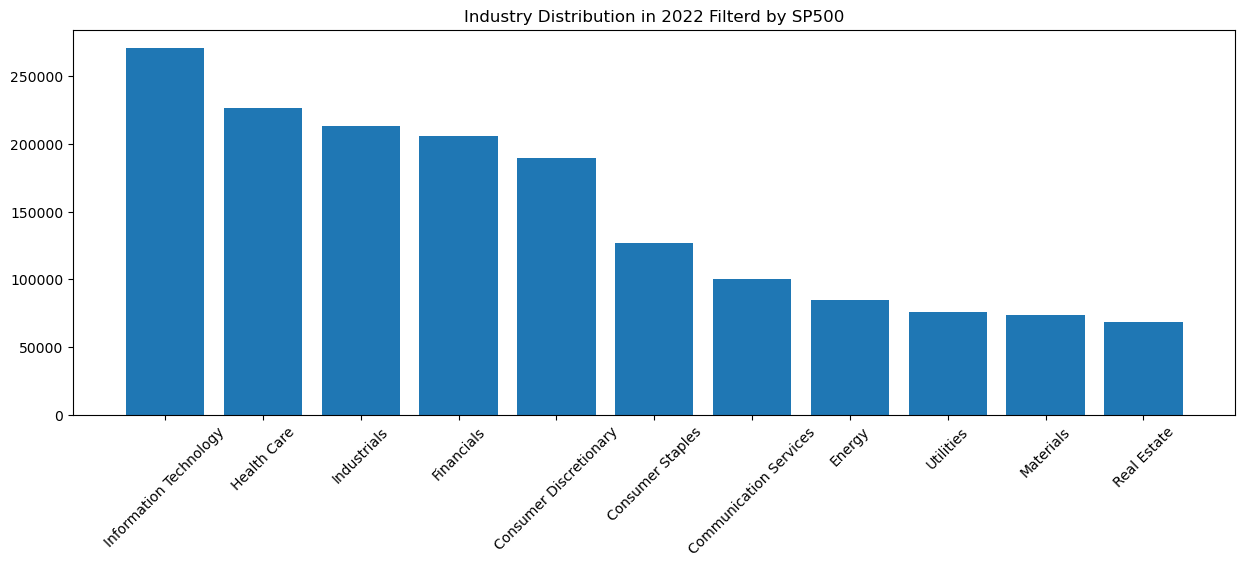

In [22]:
recent_holdings = holdings_sp500[holdings_sp500['year']==2022]
industry = recent_holdings['gics1'].value_counts()

plt.figure(figsize = (15,5))
plt.bar(industry.index, industry)
plt.title('Industry Distribution in 2022 Filterd by SP500')
plt.xticks(rotation = 45)

In [16]:
holdings_sp500.to_parquet('../data/holdings_sp500.parquet.gzip', compression='gzip')

In [20]:
recent_holdings['permno'].nunique()

578

all universe

In [17]:
parquet_file_path = '../data/price_vol_gics_all.parquet.gzip'
price_vol_gics_all = pq.read_table(parquet_file_path)
price_vol_gics_all = price_vol_gics_all.to_pandas()

In [19]:
holdings_all = holdings[holdings['permno'].isin(price_vol_gics_all['permno'])]

holdings_all = pd.merge(holdings_all, price_vol_gics_all, on = ['date', 'permno'], how = 'left')
holdings_all['gics'] = holdings_all['gics'].fillna(0)

holdings_all.head()

,date,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,...,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker
0,2021-06-30,110.0,False,False,3000.0,10104.0,3000.0,2021-03-31,3000.0,0.0,...,7899840.0,77.589996,78.209999,77.580002,-0.003329,2792000.0,2021-06,45103020.0,ORACLE SYSTEMS CORP,ORCL
1,2021-09-30,110.0,False,False,3000.0,10104.0,3000.0,2021-06-30,3000.0,0.0,...,15651919.0,91.250000,91.580002,87.120003,-0.045151,2733686.0,2021-09,45103020.0,ORACLE SYSTEMS CORP,ORCL
2,2021-12-31,110.0,False,False,3000.0,10104.0,3000.0,2021-09-30,3000.0,0.0,...,5908158.0,88.050003,88.099998,87.180000,-0.009090,2670447.0,2021-12,45103020.0,ORACLE SYSTEMS CORP,ORCL
3,2022-03-31,110.0,False,False,3000.0,10104.0,3000.0,2021-12-31,3000.0,0.0,...,9433347.0,83.110001,83.910004,82.589996,-0.007558,2668157.0,2022-03,45103020.0,ORACLE SYSTEMS CORP,ORCL
4,2022-06-30,110.0,False,False,3000.0,10104.0,3000.0,2022-03-31,3000.0,0.0,...,9888767.0,68.209999,70.250000,68.209999,0.009536,2664926.0,2022-06,45103020.0,ORACLE SYSTEMS CORP,ORCL


In [21]:
holdings_all['gics1'] = holdings_all['gics'].apply(lambda x:sector_map[int(x//1e6)] if int(x//1e6) in sector_map.keys() else 'Unknown')
holdings_all['gics2'] = holdings_all['gics'].apply(lambda x:industry_group_map[int(x//1e4)]if int(x//1e4) in industry_group_map.keys() else 'Unknown')

holdings_all.head()

,date,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,...,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker,gics1,gics2
0,2021-06-30,110.0,False,False,3000.0,10104.0,3000.0,2021-03-31,3000.0,0.0,...,78.209999,77.580002,-0.003329,2792000.0,2021-06,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services
1,2021-09-30,110.0,False,False,3000.0,10104.0,3000.0,2021-06-30,3000.0,0.0,...,91.580002,87.120003,-0.045151,2733686.0,2021-09,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services
2,2021-12-31,110.0,False,False,3000.0,10104.0,3000.0,2021-09-30,3000.0,0.0,...,88.099998,87.180000,-0.009090,2670447.0,2021-12,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services
3,2022-03-31,110.0,False,False,3000.0,10104.0,3000.0,2021-12-31,3000.0,0.0,...,83.910004,82.589996,-0.007558,2668157.0,2022-03,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services
4,2022-06-30,110.0,False,False,3000.0,10104.0,3000.0,2022-03-31,3000.0,0.0,...,70.250000,68.209999,0.009536,2664926.0,2022-06,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

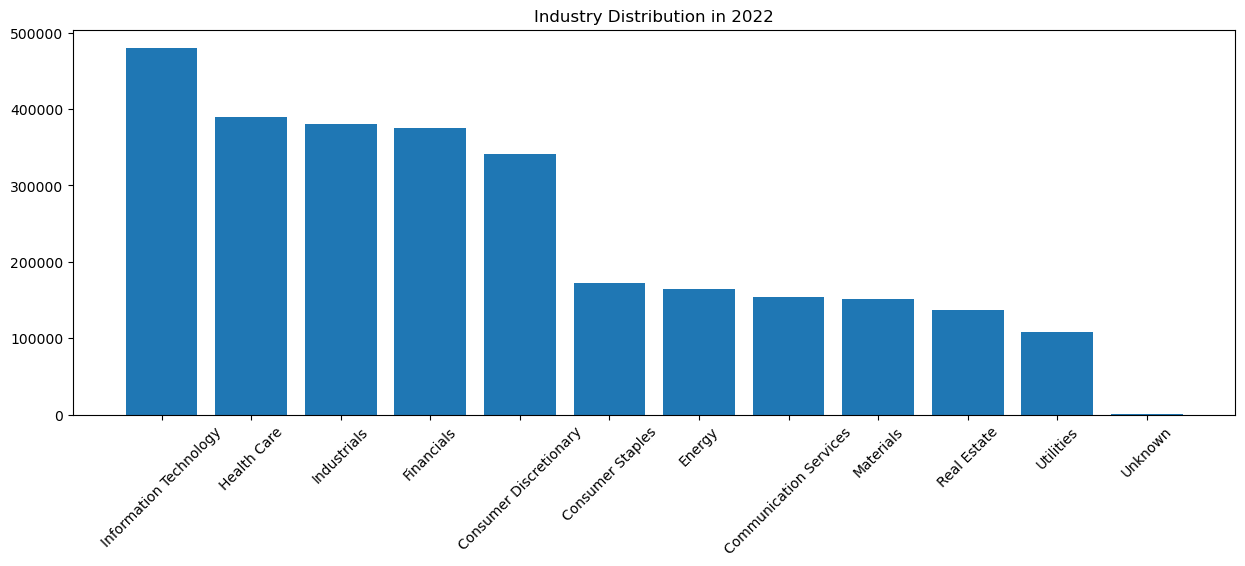

In [23]:
recent_holdings = holdings_all[holdings_all['year']==2022]
industry = recent_holdings['gics1'].value_counts()

plt.figure(figsize = (15,5))
plt.bar(industry.index, industry)
plt.title('Industry Distribution in 2022')
plt.xticks(rotation = 45)

In [24]:
recent_holdings['permno'].nunique()

2079

In [25]:
holdings_all.to_parquet('../data/holdings_all.parquet.gzip', compression='gzip')